# 1 Import cleaned data and required libraries 
- Import cleaned data generated from the previous notebook (`01_Data_Inspection_Cleaning`).
- Import all necessary libraries (please install if you do not have them).

In [46]:
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# import cleaned data
df = pd.read_parquet('data/interim/data_outliers_cleared.parquet')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1600 entries, 0 to 1609
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   number_row        1600 non-null   int64         
 1   name              1600 non-null   string        
 2   album             1600 non-null   string        
 3   release_date      1600 non-null   datetime64[ns]
 4   track_number      1600 non-null   int64         
 5   id                1600 non-null   string        
 6   uri               1600 non-null   string        
 7   acousticness      1600 non-null   float64       
 8   danceability      1600 non-null   float64       
 9   energy            1600 non-null   float64       
 10  instrumentalness  1600 non-null   float64       
 11  liveness          1600 non-null   float64       
 12  loudness          1600 non-null   float64       
 13  speechiness       1600 non-null   float64       
 14  tempo             1600 non-nu

# 2. Scale features for clustering

In [47]:
Standard_scale = StandardScaler()
scaled_df = Standard_scale.fit_transform(df.iloc[:, 7:18 ])
print('First five rows of df after scaling:')
print(scaled_df[0:5, :])
print("**********************************************************************")
print(f'Number of features of the dataset to be scaled: {scaled_df.shape[1]} ')
print("**********************************************************************")

First five rows of df after scaling:
[[-0.73964281 -0.04433332  1.12156646  3.02440969  1.26448377 -2.07818522
   0.88639398 -0.28018266 -2.40558757  0.97802594 -2.01038598]
 [ 0.8409549  -1.00955628  0.96447843  0.25422465  1.34760451  0.73608852
   0.1592254   0.180022   -1.15554953  1.05841438 -0.03952292]
 [ 0.74734928 -0.5868309   0.98691958  0.860543    1.33327335  0.68993582
   0.99301694  0.13251016 -1.17726666  1.05841438  0.05671098]
 [ 1.42041824 -0.70660309  1.07668416 -0.59132804  1.15843317  0.48207516
   2.6563351   0.23266471 -1.8982754   0.89763749  0.46835736]
 [ 0.67603071 -1.17160101  0.98691958 -0.38876325  1.36193567  0.63371975
   0.52387592  0.14848427 -1.64201325  0.89763749  0.46089916]]
**********************************************************************
Number of features of the dataset to be scaled: 11 
**********************************************************************


# 3. Dimension reduction and visualization
- PCA is uased to reduce number of features
- explained_variance_ratio_ is used to determine the proper number of variables (components) to retain

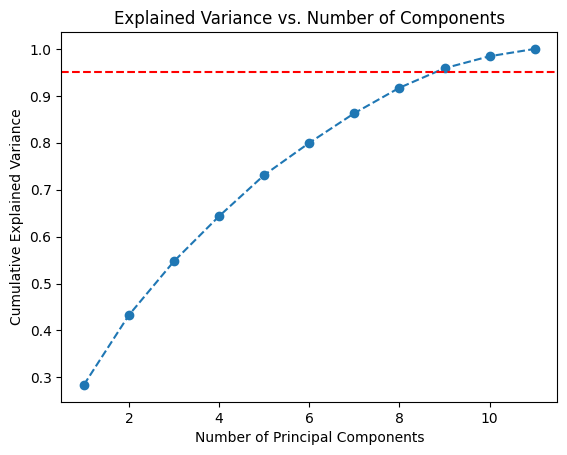

Components needed for 95% variance: 9
Original shape: (1600, 11)
Reduced shape: (1600, 9)


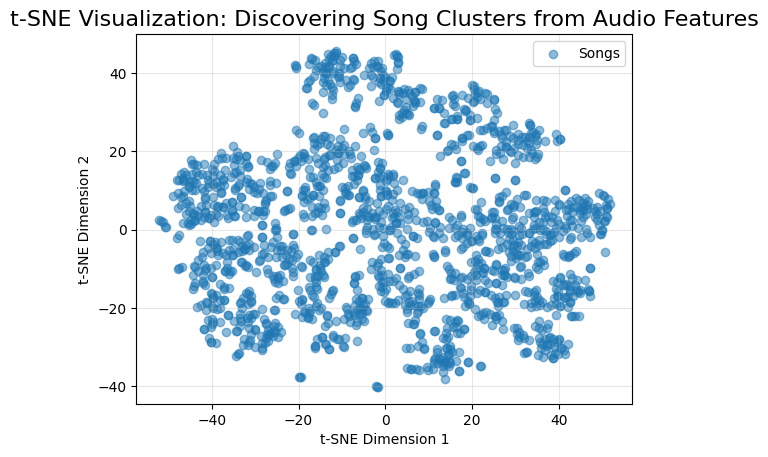

In [48]:
# Apply PCA
pca = PCA(n_components=11)
pca.fit(scaled_df)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.savefig('plots/Explained_variance_number_component.png')
plt.show()

# Find how many components needed for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Components needed for 95% variance: {n_components_95}")

# dim before and after pca applying
pca_95 = PCA(n_components=n_components_95)
df_reduced_dim = pca_95.fit_transform(scaled_df)  
print(f"Original shape: {scaled_df.shape}")
print(f"Reduced shape: {df_reduced_dim.shape}")

# Visualize data in 2D by t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(df_reduced_dim)
plt.scatter(X_tsne[:,0], X_tsne[:,1], alpha = 0.5, label='Songs')
plt.title('t-SNE Visualization: Discovering Song Clusters from Audio Features', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('plots/t-SNE_visualizatio_song_clusters.png')
plt.show()


**Findings from above cell:**
- Optimal number of dimensions is 9.
- Number of dimensions are reduced to 9 from 11.
- From the t-SNE visualization, some possible separation between clusters can be observed.  

# 4. Save reduced dimensions data into a file.
Two groups based on the above dataset split us c

In [49]:
# transfer numpy data to dataframe
df_reduced_dim_pd = pd.DataFrame(df_reduced_dim, 
                                columns=[f'PC_{i+1}' for i in range(df_reduced_dim.shape[1])])
df_reduced_dim_pd.to_parquet('data/interim/df_reduced_dim_pd.parquet')